In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch_geometric.data import InMemoryDataset, download_url, Data, Dataset
import jnpy as jp
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import to_networkx
import networkx as nx

In [2]:
#One-hot encoding for protein sequence
def seq2onehot(seq):
    """Create 26-dim embedding"""
    chars = ['-', 'D', 'G', 'U', 'L', 'N', 'T', 'K', 'H', 'Y', 'W', 'C', 'P',
             'V', 'S', 'O', 'I', 'E', 'F', 'X', 'Q', 'A', 'B', 'Z', 'R', 'M']
    vocab_size = len(chars)
    vocab_embed = dict(zip(chars, range(vocab_size)))

    # Convert vocab to one-hot
    vocab_one_hot = np.zeros((vocab_size, vocab_size), int)
    for _, val in vocab_embed.items():
        vocab_one_hot[val, val] = 1

    embed_x = [vocab_embed[v] for v in seq]
    seqs_x = np.array([vocab_one_hot[j, :] for j in embed_x])

    return seqs_x

In [3]:
# The command below upgrades gdown; otherwise, the old version of gdown cannot download files from google drive
!pip install --upgrade --no-cache-dir gdown

# The command below downloads the dataset file from my google drive.
!gdown --id 1eLkgqMEDX9ISEn-KuoeC506kagDqR4Qy

# The command below uncompresses the dataset
!tar xvzf allosteric-design-dataset.tar.gz

# The folder 'structure' contains the PDB files of all the proteins used in the dataset; 
# The 'ddg.txt' file contains the protein name, mutation, and the ddG.
#
# The format of the ddg.txt is:
# ProteinName Mutation wt_min wt_avg wt_std mt_min mt_avg mt_std corr ddg_avg ddg_std
#
# wt_min is the minimum energy of the Wild Type protein; mt_min is the minimum energy of the mutant
# wt_avg is the average energy of the Wild Type protein; mt_avg is the average energy of the mutant
# wt_std and mt_std are the standard deviation.
# corr is the correction of the ddg
# ddg_avg is the average ddg
# ddg_std is the standard deviation of ddg
#
# Please ignore the ddG and its correction. Just use the mt_min or mt_avg.
# There are also some lines that has only the protein name; please also ignore these lines.
#
# There are only ~50,000 lines in 'ddg.txt', and I'm constantly adding new data into this file.

/storage/home/sug82/scratch/apps/miniconda3/lib/python3.9/site-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1eLkgqMEDX9ISEn-KuoeC506kagDqR4Qy
To: /gpfs/scratch/sug82/apps/miniconda3/envs/large_data/allosteric-design-dataset.tar.gz
100%|████████████████████████████████████████| 150M/150M [00:02<00:00, 60.6MB/s]
structure/
structure/6VK3_A.pdb
structure/7L9U_A.pdb
structure/7CC7_A.pdb
structure/6ZU8_A.pdb
structure/7D7M_D.pdb
structure/6I53_A.pdb
structure/6LXH_A.pdb
structure/6A69_A.pdb
structure/6IJP_A.pdb
structure/6QTS_A.pdb
structure/6WW7_C.pdb
structure/6MM1_A.pdb
structure/7A23_O.pdb
structure/6KXW_A.pdb
structure/6R7F_H.pdb
structure/6H9M_A.pdb
structure/6VTY_A.pdb
structure/6JPL_A.pdb
structure/6QH4_C.pdb
structure/6S9A_A.pdb
structure/6Z3M_C.pdb
structure/6J44_A.pdb
structure/6ZPU_A.pdb
st

In [10]:
#creating my own dataset

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return "large_ddg.txt"

    @property
    def processed_file_names(self):
        return ['data.pt']    

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        # Read data into huge `Data` list.
        with open('./large_ddg.txt','r') as f:
          lines =f.readlines()
        #   lines = lines[:2]
        path ="./structure/" 
        data_list = []
        index =1
        for line in lines:
          word_list=line.split()
          if (len(word_list) > 1):
            ProteinName= line.split()[0]
            print(ProteinName)
            ChainName = ProteinName.split("_")[1]
            Mutation= line.split()[1]
            new_aa = Mutation[-1]
            old_aa = Mutation[0]
            mutation_position = int(Mutation[1:-1]) # assumption: mutation_position starts from one
            print("mutation_position", mutation_position)
            mt_ave = float(line.split()[6])
            PDBFile = path + ProteinName +".pdb"
            pdb = jp.Pdb(PDBFile)
            seq = pdb.seq()
            #my_list= pdb.contacts(cutoff=8)
            #final_list=[]
            #for i in range(len(my_list)):
              #my_list[i].pop()
              #final_list.append(my_list[i])
            arr = np.array(pdb.contacts(cutoff=8))
            arr2 = np.delete(arr, 2, axis=1)
            reversedArr = np.flip(arr2)
            final_list= np.concatenate((arr2,reversedArr ), axis=0)
            edge_index = torch.tensor(final_list, dtype=torch.long)
            edge_index=edge_index.t().contiguous()
            #print("mutation",Mutation)
            #print("old_aa", old_aa)
            #print(seq[position])
            if seq[mutation_position-1] == old_aa:
              seq = seq.replace(seq[mutation_position-1], new_aa) 
            x = torch.tensor(seq2onehot(seq), dtype=torch.float)
            print("x.shape", x.shape)
            
            data =  Data(x=x, edge_index=edge_index, y=torch.as_tensor(np.array([mt_ave])).unsqueeze(0))
            
            #print(data)
            data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        print("total samples", index)


In [11]:
dataset = MyOwnDataset(root="./Data/")

In [12]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: MyOwnDataset(152394):
Number of graphs: 152394
Number of features: 26


In [13]:
#print(dataset[0].num_nodes)
#data = dataset[0]  # Get the first graph object.

print()
#print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {dataset[0].num_nodes}')
print(f'Number of edges: {dataset[0].num_edges}')
print(f'Average node degree: {dataset[0].num_edges / dataset[0].num_nodes:.2f}')
print(f'Has isolated nodes: {dataset[0].has_isolated_nodes()}')
print(f'Has self-loops: {dataset[0].has_self_loops()}')
print(f'Is undirected: {dataset[0].is_undirected()}')


Number of nodes: 133
Number of edges: 1292
Average node degree: 9.71
Has isolated nodes: False
Has self-loops: False
Is undirected: True


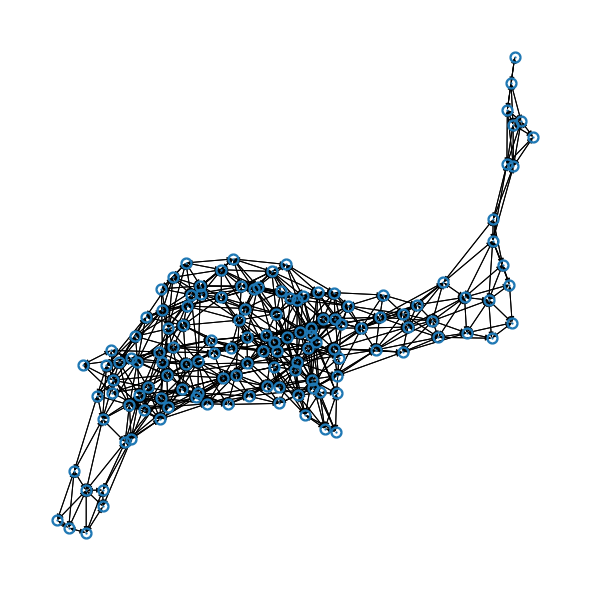

In [14]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
graph= dataset[0]
vis = to_networkx(graph)
plt.figure(1,figsize=(8,8)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_size=5,linewidths=10)
plt.show()

In [15]:
with open('./large_ddg.txt','r') as f:
  lines =f.readlines()
sample_number =0
for line in lines:
  word_list=line.split()
  if (len(word_list) > 1):
    sample_number +=1
print(sample_number) 
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:int(0.8*sample_number)]
val_dataset = dataset[int(0.8*sample_number):int(0.9*sample_number)]
test_dataset = dataset[int(0.9*sample_number):]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

152394
Number of training graphs: 121915
Number of validation graphs: 15239
Number of test graphs: 15240


In [16]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[8688, 26], edge_index=[2, 83744], y=[32, 1], batch=[8688], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[9408, 26], edge_index=[2, 89492], y=[32, 1], batch=[9408], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[8420, 26], edge_index=[2, 81002], y=[32, 1], batch=[8420], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[8924, 26], edge_index=[2, 83080], y=[32, 1], batch=[8924], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[7257, 26], edge_index=[2, 69210], y=[32, 1], batch=[7257], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[8656, 26], edge_index=[2, 81384], y=[32, 1], batch=[8656], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[9157, 26], edge_index=[2, 86910], y=[32, 1], batch=[9157], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[8777, 

In [17]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [31]:
#from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01,
                             weight_decay=10**-5)

In [15]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [16]:
import os.path as osp
from math import sqrt

import torch
import torch.nn.functional as F


def train():
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        #print(out.dtype)
        #print(data.y.dtype)
        out=out.type(torch.float64)
        #print("new type out",out.dtype)
        #print("out",out)
        #print("y", data.y)
        #print("before",data.y.ndim)
        #data.y.unsqueeze(0)
        #print("after",data.y.ndim)
        #data.y.reshape([data.y.shape(), 1])
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)

epoch_number = 0
@torch.no_grad()
def test(loader):
    mse = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
    return float(torch.cat(mse, dim=0).mean().sqrt())

Best_val_rmse=10000

for epoch in range(1, 200):
    
    train_rmse = train()
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)

    if val_rmse < Best_val_rmse:
        Best_val_rmse= val_rmse
        model_path = 'Best_Model.pth'
        torch.save(model.state_dict(), model_path)
    if epoch % 5 ==0:
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' :  train_rmse, 'Validation' : val_rmse },
                    epoch)
        writer.flush()
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
          f'Test: {test_rmse:.4f}')


Epoch: 005, Loss: 392.2058 Val: 385.8094 Test: 389.3049
Epoch: 010, Loss: 327.1881 Val: 312.2907 Test: 314.8193
Epoch: 015, Loss: 285.4248 Val: 328.5850 Test: 327.9813
Epoch: 020, Loss: 265.4052 Val: 265.9952 Test: 267.3450
Epoch: 025, Loss: 245.8500 Val: 244.0134 Test: 247.7378
Epoch: 030, Loss: 234.7426 Val: 242.2796 Test: 244.6574
Epoch: 035, Loss: 225.4649 Val: 246.1398 Test: 247.1869
Epoch: 040, Loss: 219.9294 Val: 226.4403 Test: 228.5543
Epoch: 045, Loss: 212.2987 Val: 217.4625 Test: 216.9452
Epoch: 050, Loss: 205.7388 Val: 223.8641 Test: 222.4202
Epoch: 055, Loss: 200.9462 Val: 212.0828 Test: 211.5515
Epoch: 060, Loss: 197.6764 Val: 221.2389 Test: 221.5315
Epoch: 065, Loss: 193.9444 Val: 204.7238 Test: 204.4739
Epoch: 070, Loss: 190.9291 Val: 209.0303 Test: 205.7577
Epoch: 075, Loss: 187.8070 Val: 200.0387 Test: 203.5067
Epoch: 080, Loss: 186.5124 Val: 203.3319 Test: 203.9734
Epoch: 085, Loss: 184.1217 Val: 216.6075 Test: 214.0805
Epoch: 090, Loss: 181.5547 Val: 197.1104 Test: 1

In [18]:
#Save on GPU, Load on GPU
loaded_model = GCN(hidden_channels=64)
FILE = "Best_Model.pth"
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.to(device)
loaded_model.eval()
#for param in loaded_model.parameters():
#   print(param)

GCN(
  (conv1): GCNConv(26, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)

In [20]:
from scipy.stats import pearsonr
Pearson_list=[]
import statistics

for data in train_loader:
        data = data.to(device)

        out = loaded_model(data.x, data.edge_index, data.batch)
        predicted = out.detach().cpu().numpy()
        predicted2=np.reshape(predicted , predicted.shape[0])
        ground_truth=data.y.detach().cpu().numpy()
        ground_truth2=np.reshape(ground_truth , ground_truth.shape[0])
        corr, _ = pearsonr(predicted2, ground_truth2)
        Pearson_list.append(corr)
        #print('Pearsons correlation: %.3f' % corr)
pearson=statistics.mean(Pearson_list)
print('Pearsons correlation for training dataset: %.4f' % pearson)   

Pearsons correlation for training dataset: 0.9842


In [42]:
from scipy.stats import pearsonr
Pearson_list=[]
import statistics

for data in val_loader:
        data = data.to(device)

        out = loaded_model(data.x, data.edge_index, data.batch)
        predicted = out.detach().cpu().numpy()
        predicted2=np.reshape(predicted , predicted.shape[0])
        ground_truth=data.y.detach().cpu().numpy()
        ground_truth2=np.reshape(ground_truth , ground_truth.shape[0])
        corr, _ = pearsonr(predicted2, ground_truth2)
        Pearson_list.append(corr)
        #print('Pearsons correlation: %.3f' % corr)
pearson=statistics.mean(Pearson_list)
print('Pearsons correlation for validation dataset: %.4f' % pearson)     

Pearsons correlation for validation dataset: 0.9768


In [25]:
from scipy.stats import pearsonr
Pearson_list=[]
import statistics

for data in test_loader:
        data = data.to(device)

        out = loaded_model(data.x, data.edge_index, data.batch)
        predicted = out.detach().cpu().numpy()
        predicted2=np.reshape(predicted , predicted.shape[0])
        ground_truth=data.y.detach().cpu().numpy()
        ground_truth2=np.reshape(ground_truth , ground_truth.shape[0])
        corr, _ = pearsonr(predicted2, ground_truth2)
        Pearson_list.append(corr)
        #print('Pearsons correlation: %.3f' % corr)
pearson=statistics.mean(Pearson_list)
print('Pearsons correlation for test dataset: %.4f' % pearson)       

Pearsons correlation for test dataset: 0.9758


In [ ]:
# calculate the Pearson's correlation between two variables
#from numpy.random import randn
#from numpy.random import seed
#from scipy.stats import pearsonr
# seed random number generator
#seed(1)
# prepare data
#data1 = 20 * randn(1000) + 100
#data2 = data1 + (10 * randn(1000) + 50)
# calculate Pearson's correlation
#corr, _ = pearsonr(data1, data2)
#print('Pearsons correlation: %.3f' % corr)

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ypred, label='predicted')
plt.plot(ytrue, label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

In [30]:
abs_error = []
import torch.nn as nn
absloss = nn.L1Loss(reduction= "none")
import torch.nn.functional as F
for data in test_loader:
    data = data.to(device)
    out = loaded_model(data.x, data.edge_index, data.batch)
    #print("out",out)
    #print("data.y", data.y)
    abs_error.append(absloss(out, data.y).cpu())
final = float(torch.cat(abs_error, dim=0).mean())
print("mean absolute error=", final)

mean absolute error= 107.26409149169922


In [ ]:
#FILE = "model.pth"
#torch.save(model, FILE)

#model = torch.load(FILE)
#model.eval()
#for param in model.parameters():
#    print(param)




#import torch.nn as nn

#absloss = nn.L1Loss()
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.randn(3, 5)
#output = loss(input, target)
#output.backward()


""" SAVING ON GPU/CPU 
# 1) Save on GPU, Load on CPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)
device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))

# 2) Save on GPU, Load on GPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)
# Note: Be sure to use the .to(torch.device('cuda')) function 
# on all model inputs, too!
# 3) Save on CPU, Load on GPU
torch.save(model.state_dict(), PATH)
device = torch.device("cuda")
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
# This loads the model to a given GPU device. 
# Next, be sure to call model.to(torch.device('cuda')) to convert the model’s parameter tensors to CUDA tensors
"""